In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import os

In [3]:
# =====================
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

X_train = train_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_train = train_df["HiringDecision"]

X_test = test_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test = test_df["HiringDecision"]



In [45]:
X_test.head()

,EducationLevel,ExperienceYears,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy
0,2,6,95,70,22,2
1,4,9,60,25,4,3
2,3,1,96,71,96,2
3,2,1,10,95,44,2
4,1,13,78,7,32,2


In [4]:
test_1500 = pd.read_csv("dataset/recruitment_data.csv")
X_test_1500 = test_1500.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test_1500 = test_1500["HiringDecision"]

In [5]:
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)
loaded_pipeline = joblib.load("preprocesor.pkl")
loaded_model = joblib.load("best_xgboost_model.pkl")

# Gunakan pipeline untuk mentransformasi data baru secara langsung
# Data yang dimasukkan ke pipeline ini harus sama dengan kolom pada X_train

X_test_transformed = loaded_pipeline.transform(X_test)
feature_names = loaded_pipeline.get_feature_names_out()

X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,
    index=X_test.index
)

# Lakukan prediksi
prediction = loaded_model.predict(X_test_transformed)

print("Prediksi untuk data baru:", prediction)

Prediksi untuk data baru: [0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0
 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0
 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0]


In [6]:
X_test_trans1500= loaded_pipeline.transform(X_test_1500)
feature_names = loaded_pipeline.get_feature_names_out()

X_test_trans1500 = pd.DataFrame(
    X_test_trans1500,
    columns=feature_names,
    index=X_test_1500.index
)

# Lakukan prediksi
prediction1500 = loaded_model.predict(X_test_trans1500)

In [7]:
X_test_transformed.head()

,num__InterviewScore,num__SkillScore,num__PersonalityScore,recruitment__RecruitmentStrategy_2,recruitment__RecruitmentStrategy_3,education__EducationLevel_2,education__EducationLevel_3,education__EducationLevel_4,experience__ExperienceYears_Mid,experience__ExperienceYears_Senior
0,1.530590,0.630528,-0.942264,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.306491,-0.900223,-1.553224,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.565564,0.664544,1.569459,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.442222,1.480945,-0.195535,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.936028,-1.512523,-0.602842,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, f1_score, roc_auc_score

from sklearn.metrics import precision_score, f1_score, roc_auc_score

def evaluate_by_subset(model, X, y, feature_prefix, pipeline, original_feature_name):
    results = []

    # ambil OneHotEncoder dari pipeline
    ohe = None
    for name, trans, cols in pipeline.transformers_:
        if name == feature_prefix.replace("__",""):  # misalnya "recruitment" dari "recruitment__"
            if hasattr(trans, "named_steps"):  
                # kalau pakai pipeline (ada FunctionTransformer + OneHotEncoder)
                for step_name, step in trans.named_steps.items():
                    if isinstance(step, OneHotEncoder):
                        ohe = step
                        break
            elif isinstance(trans, OneHotEncoder):
                ohe = trans
            break

    if ohe is not None:
        categories = list(ohe.categories_[0])  # kategori asli
        baseline_category = categories[0]      # kategori yang di-drop

    subset_cols = [col for col in X.columns if col.startswith(feature_prefix)]

    # Evaluasi subset untuk tiap kolom dummy
    for col in subset_cols:
        subset_idx = X[X[col] == 1].index
        if len(subset_idx) == 0:
            continue

        X_sub = X.loc[subset_idx]
        y_sub = y.loc[subset_idx]

        y_pred = model.predict(X_sub)
        y_prob = model.predict_proba(X_sub)[:, 1]

        results.append({
            "Subset": col,
            "Samples": len(y_sub),
            "Precision": precision_score(y_sub, y_pred, zero_division=0),
            "F1": f1_score(y_sub, y_pred, zero_division=0),
            "ROC_AUC": roc_auc_score(y_sub, y_prob) if len(y_sub.unique()) > 1 else None
        })

    # Evaluasi kategori baseline (semua dummy = 0)
    if subset_cols:  
        baseline_idx = X[(X[subset_cols] == 0).all(axis=1)].index
        if len(baseline_idx) > 0:
            X_sub = X.loc[baseline_idx]
            y_sub = y.loc[baseline_idx]

            y_pred = model.predict(X_sub)
            y_prob = model.predict_proba(X_sub)[:, 1]

            results.append({
                "Subset": f"{original_feature_name}={baseline_category}",
                "Samples": len(y_sub),
                "Precision": precision_score(y_sub, y_pred, zero_division=0),
                "F1": f1_score(y_sub, y_pred, zero_division=0),
                "ROC_AUC": roc_auc_score(y_sub, y_prob) if len(y_sub.unique()) > 1 else None
            })

    return pd.DataFrame(results)



In [9]:
recruitment_results = evaluate_by_subset(
    model=loaded_model,
    X=X_test_transformed,
    y=y_test,
    feature_prefix="recruitment__",
    pipeline=loaded_pipeline,
    original_feature_name="RecruitmentStrategy"
)


exp_results = evaluate_by_subset(
    model=loaded_model,
    X=X_test_transformed,
    y=y_test,
    feature_prefix="experience__",
    pipeline=loaded_pipeline,
    original_feature_name="ExperienceYear"
)

edu_results = evaluate_by_subset(
    model=loaded_model,
    X=X_test_transformed,
    y=y_test,
    feature_prefix="education__",
    pipeline=loaded_pipeline,
    original_feature_name="EducationLevel"
)


In [10]:

print("Evaluasi berdasarkan Recruitment Strategy")
display(recruitment_results)
print("Evaluasi berdasarkan Experience Level")
display(exp_results)
print("Evaluasi berdasarkan Education Level")
display(edu_results)

Evaluasi berdasarkan Recruitment Strategy


,Subset,Samples,Precision,F1,ROC_AUC
0,recruitment__RecruitmentStrategy_2,150,0.909091,0.666667,0.817798
1,recruitment__RecruitmentStrategy_3,56,1.000000,0.727273,0.836735
2,RecruitmentStrategy=1,94,0.970588,0.977778,0.945274


Evaluasi berdasarkan Experience Level


,Subset,Samples,Precision,F1,ROC_AUC
0,experience__ExperienceYears_Mid,50,1.00000,0.857143,0.880482
1,experience__ExperienceYears_Senior,191,0.95082,0.899225,0.926949
2,ExperienceYear=Junior,59,1.00000,1.000000,1.000000


Evaluasi berdasarkan Education Level


,Subset,Samples,Precision,F1,ROC_AUC
0,education__EducationLevel_2,139,1.000000,0.928571,0.958716
1,education__EducationLevel_3,74,1.000000,0.958904,0.985380
2,education__EducationLevel_4,28,0.909091,0.909091,0.922460
3,EducationLevel=1,59,0.818182,0.720000,0.753968


In [11]:
import os
# # # Nama folder yang diinginkan
folder_path = 'file_exp'

# Cek apakah folder sudah ada, jika tidak, buat folder tersebut
if not os.path.exists(folder_path):
    os.path.makedirs(folder_path)
    print(f"Folder '{folder_path}' berhasil dibuat.")

# Buat path lengkap untuk file Excel
file_path = os.path.join(folder_path, 'recruitment_results.xlsx')
# Asumsikan 'hasil_evaluasi' adalah DataFrame
recruitment_results.to_excel(file_path, index=True)

file_path = os.path.join(folder_path, 'exp_results.xlsx')
# Asumsikan 'hasil_evaluasi' adalah DataFrame
exp_results.to_excel(file_path, index=True)

file_path = os.path.join(folder_path, 'edu_results.xlsx')
# Asumsikan 'hasil_evaluasi' adalah DataFrame
edu_results.to_excel(file_path, index=True)

print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")

Hasil evaluasi telah berhasil disimpan ke: file_exp\edu_results.xlsx


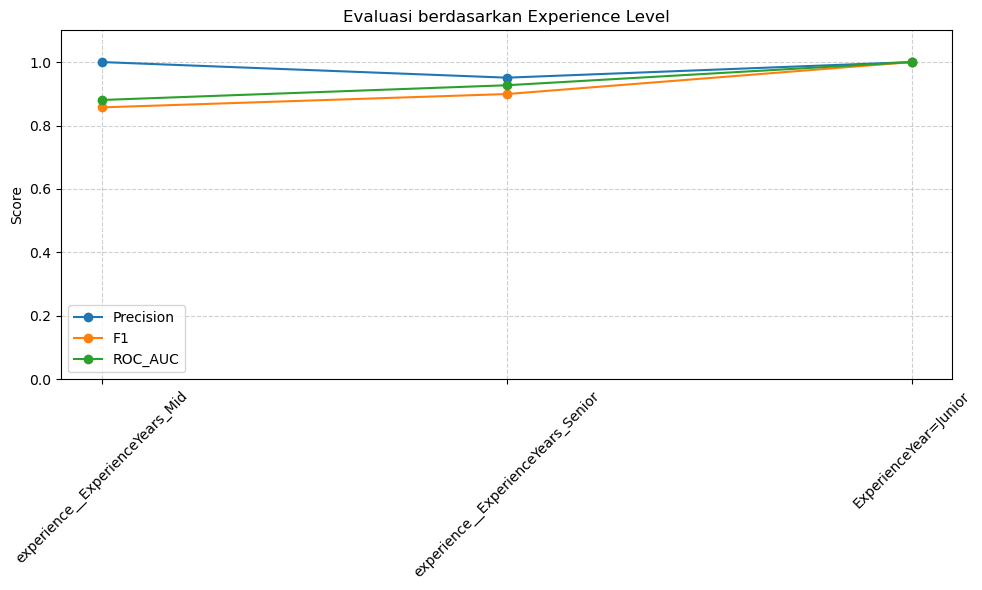

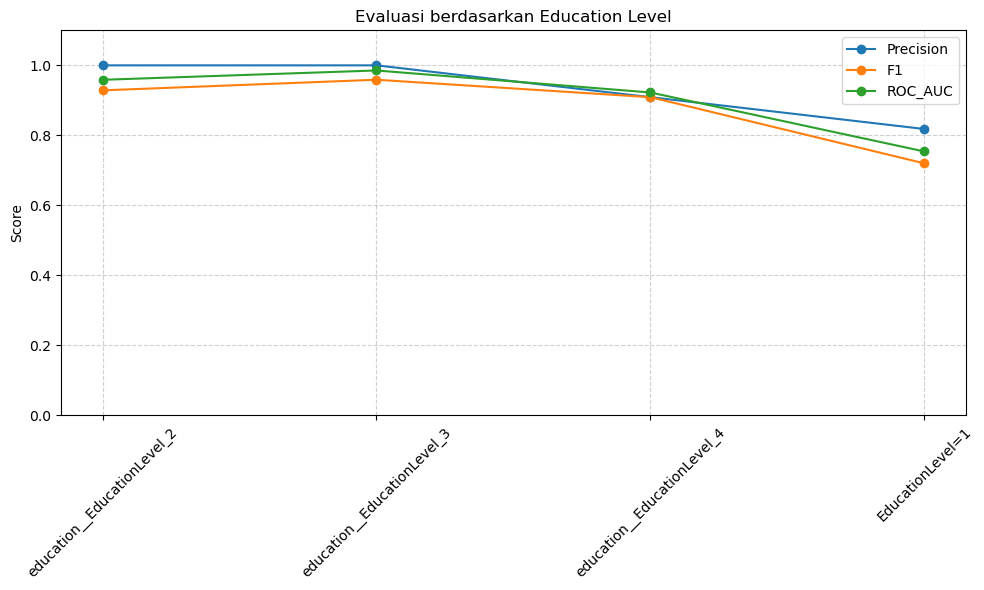

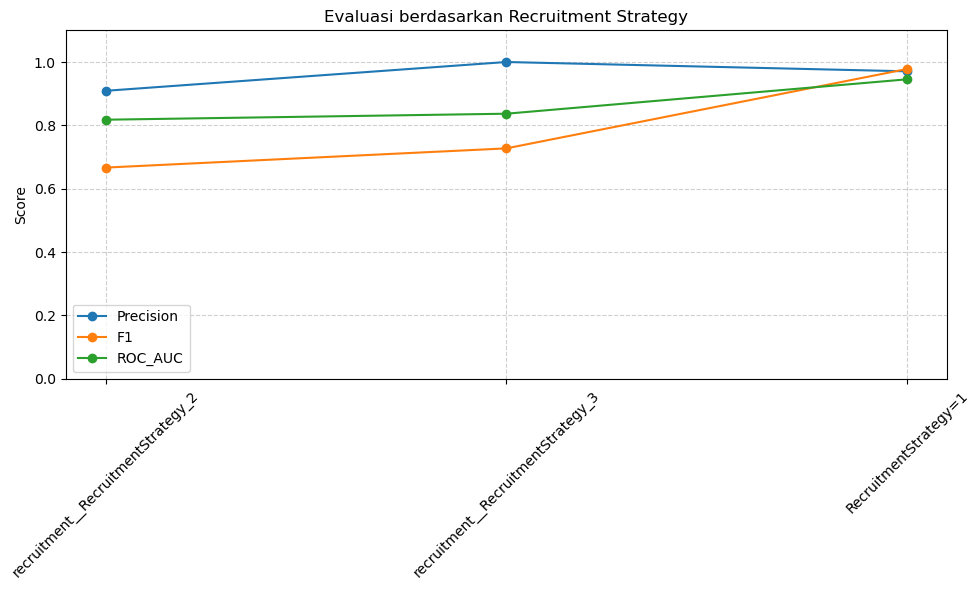

In [12]:
import matplotlib.pyplot as plt

def plot_subset_results_auto(df, title, metrics=["Precision", "F1", "ROC_AUC"]):
    """
    Plot hasil evaluasi subset secara otomatis.
    df      : DataFrame hasil evaluate_by_subset
    title   : Judul grafik
    metrics : List metrik yang mau ditampilkan
    """
    x = range(len(df))
    
    plt.figure(figsize=(10,6))
    for metric in metrics:
        if metric in df.columns:  # hanya plot kalau metrik tersedia
            plt.plot(x, df[metric], marker="o", label=metric)
    
    plt.xticks(x, df["Subset"], rotation=45)
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# ================
# Contoh pemakaian
# ================
plot_subset_results_auto(exp_results, "Evaluasi berdasarkan Experience Level")
plot_subset_results_auto(edu_results, "Evaluasi berdasarkan Education Level")
plot_subset_results_auto(recruitment_results, "Evaluasi berdasarkan Recruitment Strategy")


In [13]:
from sklearn.metrics import precision_score, f1_score, roc_auc_score

def evaluate_numeric_by_bins(model, pipeline, X_raw, y, feature, bins=3):
    results = []
    bin_labels = ["Low", "Medium", "High"][:bins]

    feature_values = X_raw[feature]
    X_bins = pd.qcut(feature_values, q=bins, labels=bin_labels, duplicates="drop")
    X_transformed = pipeline.transform(X_raw)

    for bin_label in bin_labels:
        subset_idx = X_bins[X_bins == bin_label].index
        if len(subset_idx) == 0:
            continue

        X_sub = X_transformed[subset_idx]
        y_sub = y.loc[subset_idx]

        y_pred = model.predict(X_sub)

        precision = precision_score(y_sub, y_pred, zero_division=0)
        f1 = f1_score(y_sub, y_pred, zero_division=0)
        try:
            y_prob = model.predict_proba(X_sub)[:, 1]
            roc_auc = roc_auc_score(y_sub, y_prob)
        except:
            roc_auc = None

        results.append({
            "Feature": feature,
            "Subset": bin_label,
            "Samples": len(y_sub),
            "Precision": precision,
            "F1": f1,
            "ROC_AUC": roc_auc
        })

    df = pd.DataFrame(results)
    df["Subset"] = pd.Categorical(df["Subset"], categories=bin_labels, ordered=True)
    return df.sort_values(["Feature", "Subset"]).reset_index(drop=True)


def evaluate_all_numeric(model, pipeline, X_raw, y, features, bins=3):
    all_results = []
    for feature in features:
        df_feature = evaluate_numeric_by_bins(model, pipeline, X_raw, y, feature, bins)
        all_results.append(df_feature)
    return pd.concat(all_results, ignore_index=True)


# ======================
# Contoh pemakaian
# ======================
numeric_features = ["InterviewScore", "SkillScore", "PersonalityScore"]

results_seg_num = evaluate_all_numeric(
    loaded_model, loaded_pipeline, X_test, y_test, numeric_features, bins=3
)

display(results_seg_num )


# # # Nama folder yang diinginkan
folder_path = 'file_exp'

# Cek apakah folder sudah ada, jika tidak, buat folder tersebut
if not os.path.exists(folder_path):
    os.path.makedirs(folder_path)
    print(f"Folder '{folder_path}' berhasil dibuat.")

# Buat path lengkap untuk file Excel
file_path = os.path.join(folder_path, 'results_seg_num.xlsx')
# Asumsikan 'hasil_evaluasi' adalah DataFrame
results_seg_num.to_excel(file_path, index=True)

print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")


,Feature,Subset,Samples,Precision,F1,ROC_AUC
0,InterviewScore,Low,106,0.964286,0.915254,0.950538
1,InterviewScore,Medium,94,1.000000,0.888889,0.917101
2,InterviewScore,High,100,0.942857,0.916667,0.932861
3,SkillScore,Low,101,1.000000,0.842105,0.870829
4,SkillScore,Medium,99,0.880000,0.897959,0.970000
5,SkillScore,High,100,1.000000,0.943820,0.951024
6,PersonalityScore,Low,101,0.961538,0.909091,0.905412
7,PersonalityScore,Medium,101,0.952381,0.869565,0.944211
8,PersonalityScore,High,98,0.972222,0.933333,0.957844


Hasil evaluasi telah berhasil disimpan ke: file_exp\results_seg_num.xlsx


In [14]:
y_pred = loaded_model.predict(X_test_transformed)
y_prob = loaded_model.predict_proba(X_test_transformed)[:, 1]

## Demographic Parity

In [ ]:
def demographic_parity(y_pred, sensitive_feature):
    df = pd.DataFrame({"y_pred": y_pred, "group": sensitive_feature})
    return df.groupby("group")["y_pred"].mean()

dp_edu = demographic_parity(y_pred, X_test["EducationLevel"])
display(dp_edu)

group
1    0.186441
2    0.187050
3    0.472973
4    0.392857
Name: y_pred, dtype: float64

In [52]:
def demographic_parity(y_pred, sensitive_feature, mapping_dict=None):
    df = pd.DataFrame({"y_pred": y_pred, "group": sensitive_feature})
    
    # Hitung jumlah total, jumlah positif, dan positive_rate
    summary = df.groupby("group").agg(
        count=("y_pred", "size"),
        positives=("y_pred", "sum")
    )
    summary["positive_rate"] = summary["positives"] / summary["count"]
    
    # Kalau ada mapping dictionary, ganti index dengan nama kategori
    if mapping_dict is not None:
        summary.index = summary.index.map(mapping_dict)
    
    return summary


In [ ]:
def bin_experience(v):
    if v <= 2:
        return "Junior"
    elif v <= 5:
        return "Mid"
    else:
        return "Senior"

X_test["ExperienceLevel"] = X_test["ExperienceYears"].apply(bin_experience)

In [56]:
def bin_experience(v):
    if v <= 2:
        return "Exp_Junior"
    elif v <= 5:
        return "Exp_Mid"
    else:
        return "Exp_Senior"

X_test["ExperienceLevel"] = X_test["ExperienceYears"].apply(bin_experience)

In [58]:
edu_map = {
    1: "HighSchool",
    2: "Bachelor",
    3: "Master",
    4: "PhD"
}

dp_edu = demographic_parity(y_pred, X_test["EducationLevel"], mapping_dict=edu_map)


recruit_map = {
    1: "Agresif (Headhunter)",
    2: "Moderat (Online/Jobportal)",
    3: "Konservatif (Offline/Walk-in)"
}

dp_recruit = demographic_parity(y_pred, X_test["RecruitmentStrategy"], mapping_dict=recruit_map)



dp_exp = demographic_parity(y_pred, X_test["ExperienceLevel"])
display(dp_edu, dp_recruit, dp_exp)

,count,positives,positive_rate
group,,,
HighSchool,59,11,0.186441
Bachelor,139,26,0.187050
Master,74,35,0.472973
PhD,28,11,0.392857


,count,positives,positive_rate
group,,,
Agresif (Headhunter),94,68,0.723404
Moderat (Online/Jobportal),150,11,0.073333
Konservatif (Offline/Walk-in),56,4,0.071429


,count,positives,positive_rate
group,,,
Exp_Junior,59,13,0.220339
Exp_Mid,50,9,0.180000
Exp_Senior,191,61,0.319372


## Equal Opportunity (EO)
### diukur dengan True Positive Rate (TPR) per grup → apakah setiap kelompok punya peluang sama untuk diprediksi positif ketika mereka sebenarnya memang positif.

In [60]:
from sklearn.metrics import confusion_matrix

def equal_opportunity(y_true, y_pred, sensitive_feature, mapping_dict=None):
    results = []
    groups = sensitive_feature.unique()

    for g in groups:
        mask = (sensitive_feature == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]

        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g, labels=[0,1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

        label = mapping_dict[g] if mapping_dict and g in mapping_dict else g
        results.append({
            "group": label,
            "true_positives": tp,
            "false_negatives": fn,
            "tpr": round(tpr, 3)
        })
    
    return pd.DataFrame(results)


In [61]:
# Education Level
eo_edu = equal_opportunity(y_test, y_pred, X_test["EducationLevel"], mapping_dict=edu_map)
display(eo_edu)

# Recruitment Strategy
eo_recruit = equal_opportunity(y_test, y_pred, X_test["RecruitmentStrategy"], mapping_dict=recruit_map)
display(eo_recruit)

# Experience Level
eo_exp = equal_opportunity(y_test, y_pred, X_test["ExperienceLevel"])
display(eo_exp)


,group,true_positives,false_negatives,tpr
0,Bachelor,26,4,0.867
1,PhD,10,1,0.909
2,Master,35,3,0.921
3,HighSchool,9,5,0.643


,group,true_positives,false_negatives,tpr
0,Moderat (Online/Jobportal),10,9,0.526
1,Konservatif (Offline/Walk-in),4,3,0.571
2,Agresif (Headhunter),66,1,0.985


,group,true_positives,false_negatives,tpr
0,Exp_Senior,58,10,0.853
1,Exp_Junior,13,0,1.000
2,Exp_Mid,9,3,0.750


## Predict Proba 


In [ ]:

# ==== 1. Average Predicted Probability per Group ====
def avg_predicted_proba(y_proba, sensitive_feature, mapping_dict=None):
    df = pd.DataFrame({"y_proba": y_proba, "group": sensitive_feature})
    if mapping_dict:
        df["group"] = df["group"].map(mapping_dict)
    return df.groupby("group")["y_proba"].mean()



# ==== Contoh Pemakaian untuk Education Level ====
# Asumsi y_proba dari model: y_proba = model.predict_proba(X_test)[:,1]

# 1. Average probability per group
avg_proba_edu = avg_predicted_proba(y_prob, X_test["EducationLevel"], mapping_dict=edu_map)
display(avg_proba_edu)
# Recruitment Strategy
avg_probaecruit = equal_opportunity(y_test, y_pred, X_test["RecruitmentStrategy"], mapping_dict=recruit_map)
display(eo_recruit)

# Experience Level
eo_exp = equal_opportunity(y_test, y_pred, X_test["ExperienceLevel"])
display(eo_exp)



group
Bachelor      0.222169
HighSchool    0.203157
Master        0.473022
PhD           0.397453
Name: y_proba, dtype: float32

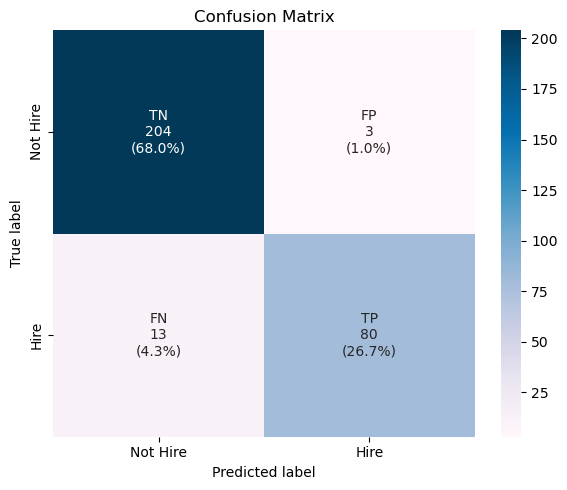

In [15]:
cm = confusion_matrix(y_test, prediction)
cm_sum = np.sum(cm)
cm_perc = cm / cm_sum * 100

# === TP, FP, FN, TN positions ===
group_names = np.array([["TN", "FP"],
                        ["FN", "TP"]])

# === Create combined label: label \n percentage ===
labels = np.array([["{0}\n{1:,}\n({2:.1f}%)".format(name, val, perc)
                    for name, val, perc in zip(group_row, cm_row, perc_row)]
                   for group_row, cm_row, perc_row in zip(group_names, cm, cm_perc)])

# === Plot heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='',cmap='PuBu', cbar=True,
            xticklabels=["Not Hire", "Hire"],
            yticklabels=["Not Hire", "Hire"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

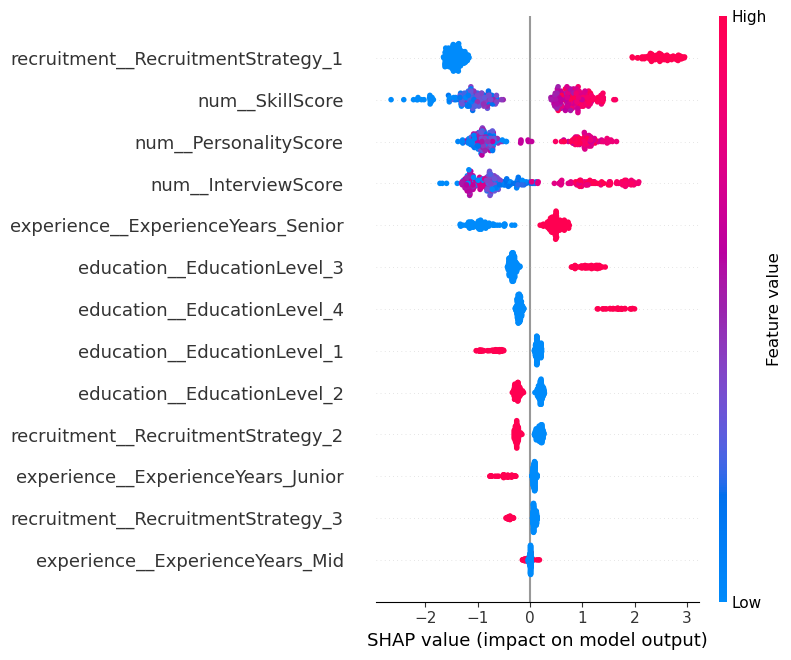

In [16]:
import shap
load_pipeline = joblib.load("preprocesor_none.pkl")
load_model = joblib.load("best_xgboost_model_none.pkl")

# Gunakan pipeline untuk mentransformasi data baru secara langsung
# Data yang dimasukkan ke pipeline ini harus sama dengan kolom pada X_train

X_test_trans= load_pipeline.transform(X_test)
feature_names = load_pipeline.get_feature_names_out()

X_test_trans = pd.DataFrame(
    X_test_trans,
    columns=feature_names,
    index=X_test.index
)
explainer = shap.Explainer(load_model)


shap_values = explainer(X_test_trans )
shap.summary_plot(shap_values, X_test_trans)




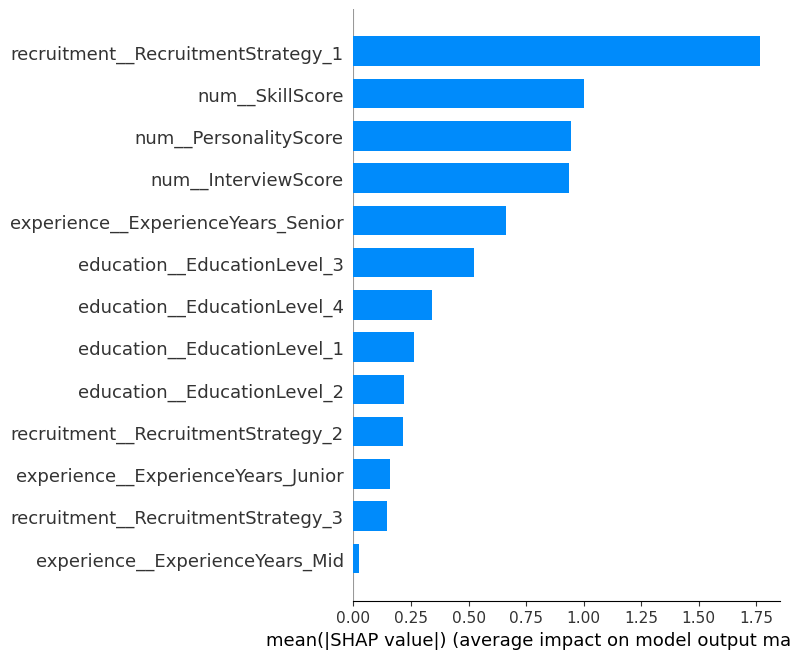

In [17]:
import shap
import matplotlib.pyplot as plt

# Buat explainer khusus untuk tree-based model
explainer = shap.TreeExplainer(load_model)

# Hitung shap values untuk X_test_trans
shap_values = explainer.shap_values(X_test_trans)

# Plot Top 10 feature importance versi SHAP
shap.summary_plot(shap_values, X_test_trans, plot_type="bar", max_display=13)
